# Real vs fake faces

Author: Xiangbo Gao, xiangbog@uci.edu, https://github.com/XiangboGaoBarry

Course Project, UC Irvine, Math 10, S22

## Introduction

This project use the dataset from https://www.kaggle.com/datasets/uditsharma72/real-vs-fake-faces, aiming to train a model to distinguish between fake and real images.

For adapting the 100MB disk limit of deepnote and for simplicity, I removed all the medium and hard fake images from the dataset. Around 60% of real images are also deleted, which results in 240 fake images and 343 real images.

By default, each image is reshaped to 32 by 32. I also evaluate the performance of different image size in the last section

## Main portion of the project

### Data preprocessing and visualization

In [ ]:
from PIL import Image
import os
import torch
import pandas as pd
import numpy as np
import altair as alt
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import random

### Data loading

Loading all the images to a dataframe or a python list.

The python list version is used for training neural networks

In [ ]:
dim = 32

### Loading data ###
# return dataframe if to_df is True, 
# otherwise return a list of unshuffled (image, label) pairs
def read_images(path="data", to_df=True, dim=32):
    if to_df:
        data_dict = {f"pixel{i}":[] for i in range(dim*dim*3)}
        data_dict["label"] = []
        df = pd.DataFrame(data_dict)
    else:
        img_list = []
    
    idx = 0
    for label, classname in enumerate(["fake", 'real']):
        class_path = f"{path}/{classname}"
        for filename in tqdm(os.listdir(class_path)):
            image_path = f"{class_path}/{filename}"
            try:
                img = Image.open(image_path)
                img = img.resize((32,32))
            except Exception as e:
                raise e
            if to_df:
                img_np = np.array(img)
                img_label = np.concatenate((img_np.flatten(), np.array([label])))
                df.loc[idx] = list(img_label)
                idx += 1
            else:
                img_list.append((img, label))
    return df if to_df else img_list

def split_set(dataset, ratio=0.8, is_df=True):
    if is_df:
        return train_test_split(dataset.iloc[:,:-1], dataset["label"], train_size=ratio)
    else:
        length = len(dataset)
        dataset = random.sample(dataset, length)
        return dataset[:int(ratio*length)], dataset[int((1-ratio)*length):]

In [ ]:
df = read_images()

100%|██████████| 343/343 [00:09<00:00, 34.47it/s]


In [ ]:
X_train, X_test, y_train, y_test = split_set(df, 0.8)

In [ ]:
alt.Chart(df[["label"]], title="target distribution").mark_bar(size=10).encode(
    x = "label:N",
    y = "count()",
    color = "label:N"
)

alt.Chart(...)

In [ ]:
fake_img = df[df["label"]==0].iloc[1].to_numpy()[:-1].reshape(dim, dim, 3).astype(int)
real_img = df[df["label"]==1].iloc[1].to_numpy()[:-1].reshape(dim, dim, 3).astype(int)

fake image


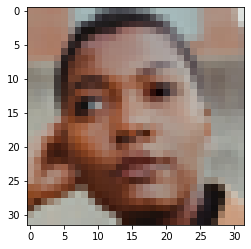

real image


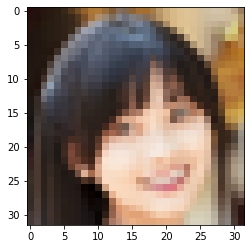

In [ ]:
print("fake image")
plt.imshow(fake_img)
plt.show()
print("real image")
plt.imshow(real_img)
plt.show()

### Logistic Regression with different regularization strength

In [ ]:
from sklearn.linear_model import LogisticRegression
test_acc = []
weight_decays = [10,1,0.1,0.01,1e-3,1e-4,1e-5,1e-6,0]
for wd in tqdm(weight_decays):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ('reg', LogisticRegression(penalty='l2', C=wd, max_iter=5000) if wd 
        else LogisticRegression(max_iter=5000))
    ])
    pipe.fit(X_train, y_train)
    test_acc.append(pipe.score(X_test, y_test))

100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


[0.5641025641025641, 0.5641025641025641, 0.5555555555555556, 0.5555555555555556, 0.5726495726495726, 0.5811965811965812, 0.5811965811965812, 0.5811965811965812, 0.5641025641025641]


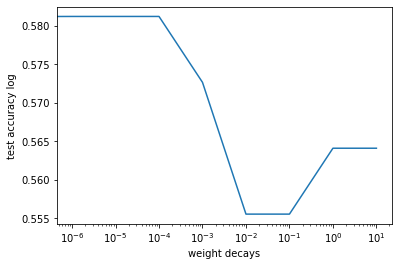

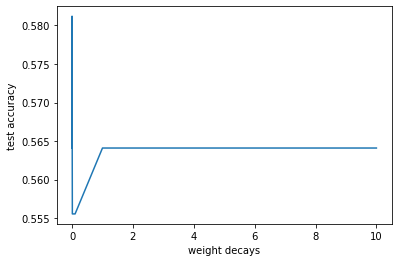

In [ ]:
print(test_acc)
plt.plot(weight_decays, test_acc)
plt.ylabel("test accuracy log")
plt.xlabel("weight decays")
plt.xscale('log')
plt.show()
plt.plot(weight_decays, test_acc)
plt.ylabel("test accuracy")
plt.xlabel("weight decays")
plt.show()

### Analysis

The highest accuracy achieved using logistic regression is $58.1\%$, where `l2 penalty` is set to be $1e-6$

As the coefficient of l2 penalty increase, the test accuracy tend to decrease. This is beacause the model experiences a very severe underfitting. Therefore, the model complexity needs to be increased.

Notice that the model with `l2 penalty=0` also has low accuracy.

### Polynomial Regression with different degrees

In [ ]:
def polynomial(df, n):
    cols = dim*dim*3
    df = df.copy()
    df_sub = df[:cols].copy()
    for p in range(2,n+1):
        df_ploy = df_sub**2
        ploy_names = {oname: f"{oname}_poly{p}" for oname in df_sub.columns}
        df_ploy = df_ploy.rename(columns=ploy_names)
        df[list(ploy_names.values())] = df_ploy
    return df

Because the data has very high dimension, instead of using `sklearn.preprocessins.PloynomialFeatures` 
to calculate all 2nd degree combinations, we define `ploy` which only calculate `x^2` for each dimension. 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
test_acc = []
ploy = [1,2,3,4,5,6]
for p in tqdm(ploy):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ('reg', LogisticRegression(penalty='l2', C=1e-6, max_iter=5000))
    ])
    X_train_ploy = polynomial(X_train, p)
    pipe.fit(X_train_ploy, y_train)
    X_test_ploy = polynomial(X_test, p)
    test_acc.append(pipe.score(X_test_ploy, y_test))

[0.5811965811965812, 0.5811965811965812, 0.5811965811965812, 0.5811965811965812, 0.5811965811965812, 0.5811965811965812]


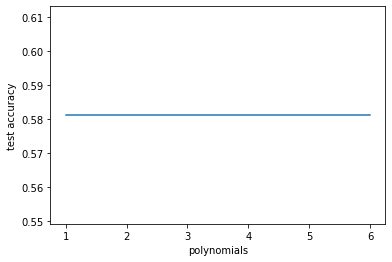

In [ ]:
print(test_acc)
plt.plot(ploy, test_acc)
plt.ylabel("test accuracy")
plt.xlabel("polynomials")
plt.show()

Unfortunately, simply increase the degree of each dimension does not help.

### Decision Tree

Visualize the feature importance of the decision tree or random forest classifiers. 

The feature importances are reshaped to the same shape of a image. For better visualization, A gaussian filter with $\sigma = 5$ is applied to the reshaped feature importance.

The display results will be self-explaintory.

In [ ]:
def show_attention(clf):
    from scipy.ndimage import gaussian_filter
    fig, ax = plt.subplots(1, 3, figsize=(10,8))
    importances = clf.feature_importances_.reshape(dim,dim, 3).mean(-1)
    filtered_importance = gaussian_filter(importances, sigma=5)
    normalized_importance = filtered_importance/(filtered_importance.max()-filtered_importance.min())
    ax[0].imshow(filtered_importance, cmap='gray')
    ax[0].set_title("attention map")
    ax[1].imshow(real_img/255.)
    ax[1].set_title("face image")
    ax[2].imshow(real_img/255. * 0.2 + np.expand_dims(normalized_importance,-1).repeat(3, axis=2) * 0.7)
    ax[2].set_title("face image + attention map")
    plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
leaf_nodes = range(20,300,30)
max_depths = range(2,20,2)
test_acc = np.zeros((len(leaf_nodes), len(max_depths)))
for idx_leaf, leaf_node in tqdm(enumerate(leaf_nodes)):
    for idx_depth, max_depth in enumerate(max_depths):
        tree = DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=leaf_node)
        tree.fit(X_train, y_train)
        test_acc[idx_leaf, idx_depth] = tree.score(X_test, y_test)

10it [02:34, 15.47s/it]


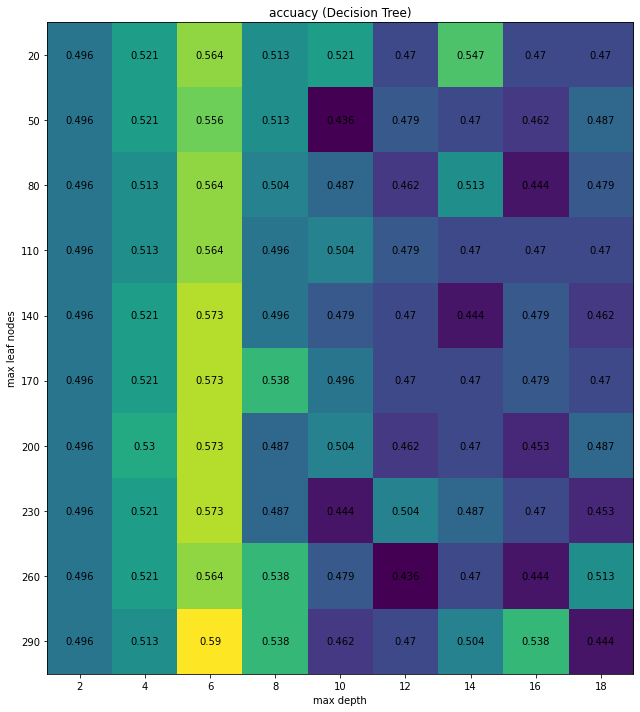

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(test_acc)

ax.set_xticks(np.arange(len(max_depths)), labels=max_depths)
ax.set_yticks(np.arange(len(leaf_nodes)), labels=leaf_nodes)

for i in range(len(leaf_nodes)):
    for j in range(len(max_depths)):
        text = ax.text(j, i, round(test_acc[i, j],3),
                       ha="center", va="center", color="black")

ax.set_title("accuacy (Decision Tree)")
ax.set_xlabel("max depth")
ax.set_ylabel("max leaf nodes")
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=6, max_leaf_nodes=290)
tree.fit(X_train, y_train)
test_acc = tree.score(X_test, y_test)
print(tree.score(X_train, y_train))
print(test_acc)

0.7424892703862661
0.5811965811965812


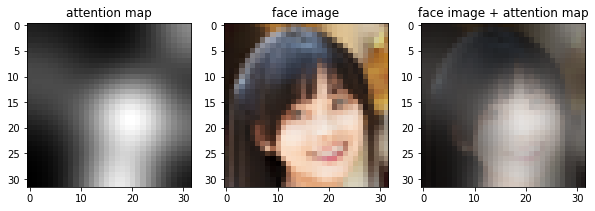

In [ ]:
show_attention(tree)

### Analysis

Decision tree reaches 58.11% accuracy in classification. Although it is not very high, it does tend to pay attention to the facial features of each face image

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
leaf_nodes = range(20,300,30)
max_depths = range(2,20,2)
test_acc = np.zeros((len(leaf_nodes), len(max_depths)))
for idx_leaf, leaf_node in tqdm(enumerate(leaf_nodes)):
    for idx_depth, max_depth in enumerate(max_depths):
        tree = RandomForestClassifier(n_estimators=100, max_depth=max_depth, max_leaf_nodes=leaf_node)
        tree.fit(X_train, y_train)
        test_acc[idx_leaf, idx_depth] = tree.score(X_test, y_test)

10it [03:28, 20.88s/it]


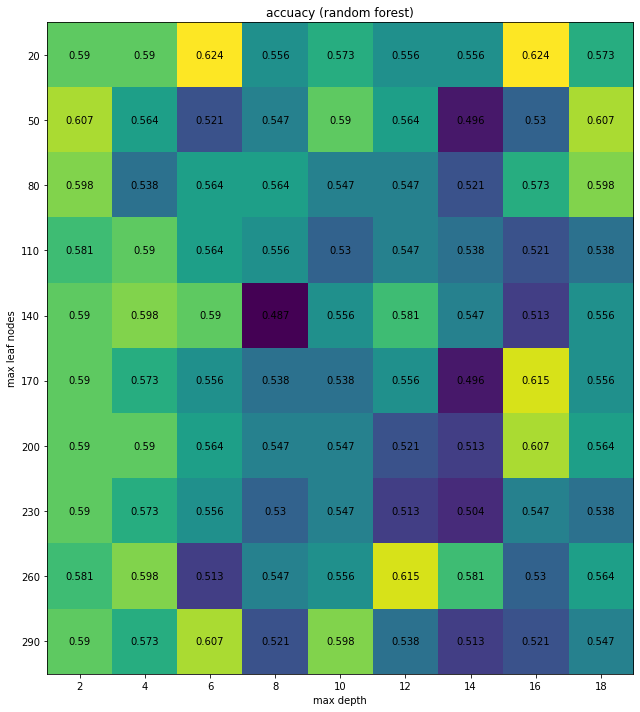

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(test_acc)

ax.set_xticks(np.arange(len(max_depths)), labels=max_depths)
ax.set_yticks(np.arange(len(leaf_nodes)), labels=leaf_nodes)

for i in range(len(leaf_nodes)):
    for j in range(len(max_depths)):
        text = ax.text(j, i, round(test_acc[i, j],3),
                       ha="center", va="center", color="black")

ax.set_title("accuacy (random forest)")
ax.set_xlabel("max depth")
ax.set_ylabel("max leaf nodes")
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = DecisionTreeClassifier(max_depth=16, max_leaf_nodes=20)
forest.fit(X_train, y_train)
test_acc = forest.score(X_test, y_test)
print(forest.score(X_train, y_train))
print(test_acc)

0.8669527896995708
0.5470085470085471


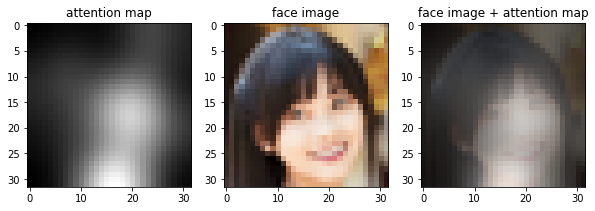

In [ ]:
show_attention(forest)

### Analysis

Random forest reaches 62.4% accuracy in classification. Similiar to decision tree, it tends to pay attention to the facial features of each face image

### Fully Connected Neural Networks

**Data loading and preprocessing**

This block of code basically putting the list of images to a pytorch dataloader module. The data is loading in this way for the ease of changing some hyper-parameters, e.g. batch_size.

Reference:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = read_images(to_df=False)

class Dataset:
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform:
            return self.transform(img), label
        else:
            return img, label 

trainset, testset = split_set(dataset, is_df=False)
traindata = Dataset(trainset, transform=transform)
testdata = Dataset(testset, transform=transform)
batch_size = 20
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 343/343 [00:07<00:00, 48.93it/s]


**Model trainning and evaluation**

This block of code includes the full process of training and inference a basic neural networks, including criterion (loss function), model forwarding, backpropagation, accuracy calculating, etc.

Reference:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
def train_eval(net, conv=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), weight_decay=1e-3, lr=0.001)
    train_loss = []
    test_loss = []
    test_acc = []
    for epoch in range(100):
        running_loss_train = 0.0
        running_loss_test = 0.0
        succ = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            if not conv:
                inputs = inputs.reshape(inputs.shape[0],-1)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item()
        train_loss.append(running_loss_train / i)
        with torch.no_grad():
            for i, data in enumerate(test_loader, 0):
                inputs, labels = data
                if not conv:
                    inputs = inputs.reshape(inputs.shape[0],-1)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss_test += loss.item()
                succ += (torch.argmax(outputs, axis=1) == labels).int().sum()
        test_loss.append(running_loss_test / i)
        print(f"trainloss:{running_loss_train} | testloss:{running_loss_test} | accuarcy:{succ/len(testdata)}")
        test_acc.append(succ/len(testdata))
    return train_loss, test_loss, test_acc

**Model definition**

Define the architecture of model. A very basic fully connected neural networks including 4 linear layers and 3 activation layers.

Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class FCNet(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        self.fc1 = nn.Linear(3*dim*dim, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 30)
        self.fc4 = nn.Linear(30, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

fcnet = FCNet()




In [ ]:
train_loss, test_loss, test_acc = train_eval(fcnet)

trainloss:16.56961476802826 | testloss:15.754675149917603 | accuarcy:0.5931477546691895
trainloss:15.426325619220734 | testloss:14.719747364521027 | accuarcy:0.6531049013137817
trainloss:14.581692814826965 | testloss:14.169351756572723 | accuarcy:0.6980727910995483
trainloss:13.379856526851654 | testloss:12.90772658586502 | accuarcy:0.7601712942123413
trainloss:11.982272148132324 | testloss:12.41127060353756 | accuarcy:0.7880085706710815
trainloss:10.84951938688755 | testloss:11.971969366073608 | accuarcy:0.7580299973487854
trainloss:8.479621469974518 | testloss:13.28071266412735 | accuarcy:0.7773019075393677
trainloss:8.746856726706028 | testloss:15.003946974873543 | accuarcy:0.7880085706710815
trainloss:7.791025534272194 | testloss:11.875941455364227 | accuarcy:0.8115631937980652
trainloss:5.54453968256712 | testloss:11.76796056702733 | accuarcy:0.8436830639839172
trainloss:5.161540012806654 | testloss:14.999820500612259 | accuarcy:0.8137044906616211
trainloss:5.725048944354057 | tes

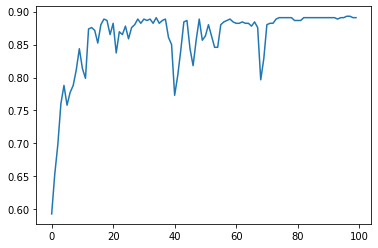

In [ ]:
plt.plot(list(range(len(test_acc))), test_acc)
plt.show()

**Analysis**

We can see that Neural Networks is much powerful for this image recognition task, where a basic neural networks reaches almostly 90% of classification accuracy.

### Convolutional Neural Networks

**Model definition**

Define the architecture of model. A very basic convolutional connected neural networks including 2 convolutional layers, 3 linear layers, 4 activation layers, and 1 pooling layers.

Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnet = CNet()

In [ ]:
train_loss, test_loss, test_acc = train_eval(cnet, conv=True)

trainloss:16.5655797123909 | testloss:16.32100421190262 | accuarcy:0.5952890515327454
trainloss:16.322040677070618 | testloss:16.010993480682373 | accuarcy:0.5952890515327454
trainloss:16.127350330352783 | testloss:15.929425418376923 | accuarcy:0.5952890515327454
trainloss:16.35239452123642 | testloss:15.827909409999847 | accuarcy:0.5952890515327454
trainloss:16.37032687664032 | testloss:16.16121196746826 | accuarcy:0.5952890515327454
trainloss:16.195215940475464 | testloss:15.744493067264557 | accuarcy:0.5952890515327454
trainloss:15.924577534198761 | testloss:15.57081800699234 | accuarcy:0.599571704864502
trainloss:15.660198509693146 | testloss:15.555176556110382 | accuarcy:0.6274089813232422
trainloss:15.40750116109848 | testloss:15.490601539611816 | accuarcy:0.599571704864502
trainloss:15.296328485012054 | testloss:15.193099200725555 | accuarcy:0.6038544178009033
trainloss:14.938752591609955 | testloss:14.573900401592255 | accuarcy:0.6638115644454956
trainloss:15.293941766023636 | 

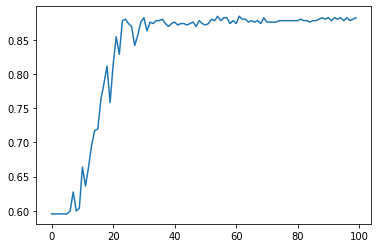

In [ ]:
plt.plot(list(range(len(test_acc))), test_acc)
plt.show()

## Summary

Logistic regression, polynonimal regression and decision tree only achieve $58.1\%$ accuracy.

Random forest achieve $65.8\%$ accuracy.

Fully Connected Neural networks achieves $89.0\%$ accuracy

Convolutional Neural nerworks achieves $87.8\%$ accuracy

## References

* What is the source of your dataset(s)?

https://www.kaggle.com/datasets/uditsharma72/real-vs-fake-faces

* Were any portions of the code or ideas taken from another source?  List those sources here and say how they were used.

The idea of Neural Networks is taken from two Deep learing Courses, CS172B & CS178. The knowledge of Image loading and preprocessing is taken from a computer vision course CS116.

* List other references that you found helpful.

https://pillow.readthedocs.io/en/stable/reference/Image.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b99b8b54-13fd-4fb0-af5c-b858404318e1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>